# Stage 1:

## Unsupervised clustering to create a model that labels the output logs:

Uses the data with software fault injection - FLP and NOP

In [1]:
from time import time
import os, random, math
from itertools import permutations

import numpy as np

import pandas as pd

import scipy as sp
import scipy.stats as stats
from scipy.stats import spearmanr

from pypair.association import binary_continuous

from gensim import utils
import gensim.parsing.preprocessing as gsp

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mixed_naive_bayes import MixedNB

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

import seaborn as sns

import pickle
import json

In [92]:
path = "Sklearn Models/"

In [93]:
filters = [
           gsp.strip_tags, 
           #gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

In [94]:
def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    s = s.replace("\\n", "")
    for f in filters:
        s = f(s)
    return s

In [95]:
nop_fault_data = pd.read_csv("VerifyPIN_nop_run_random_faulty_executables.csv")
flp_fault_data = pd.read_csv("VerifyPIN_flp_run_fixed_faulty_executables.csv")
none_fault_data = pd.read_csv("VerifyPIN_none.csv")

In [96]:
frames = [nop_fault_data, flp_fault_data, none_fault_data]
total_data = pd.concat(frames, ignore_index=True)

In [97]:
total_size = total_data.shape[0]
print("Size of total data: %i" %(total_size))

flp_size = total_data[total_data["Fault_Type"] == "FLP"].shape[0]
print("Size of FLP data: %i with %.3f%%" 
      %(flp_size, flp_size/total_size * 100))

nop_size = total_data[total_data["Fault_Type"] == "NOP"].shape[0]
print("Size of NOP data: %i with %.3f%%" 
      %(nop_size, nop_size/total_size * 100))

none_size = total_data[total_data["Fault_Type"] == "NONE"].shape[0]
print("Size of NONE data: %i with %.3f%%" 
      %(none_size, none_size/total_size * 100))

Size of total data: 602050
Size of FLP data: 199996 with 33.219%
Size of NOP data: 202054 with 33.561%
Size of NONE data: 200000 with 33.220%


In [98]:
X_train_label, X_test_label = train_test_split(total_data, random_state = 0)

In [101]:
vectorizer_output = TfidfVectorizer()
X_train_vec_output = vectorizer_output.fit_transform(X_train_label['Output'])

In [102]:
true_k = 4
model_log = KMeans(n_clusters=true_k, init='random', max_iter=100, n_init=5)
model_log.fit(X_train_vec_output)

KMeans(init='random', max_iter=100, n_clusters=4, n_init=5)

In [105]:
predicted_log_label = model_log.predict(vectorizer_output.transform(total_data['Output'].map(lambda x: clean_text(x))))
total_data['Label_Log'] = predicted_log_label
total_data.to_csv('clusters.csv')

## Unsupervised clustering to create a model that labels the error logs:

Uses the data with software fault injection - FLP and NOP

In [107]:
X_train_label['Error'] = X_train_label['Error'].map(lambda x: clean_text(x))

In [108]:
vectorizer_error = TfidfVectorizer()
X_train_vec_error = vectorizer_error.fit_transform(X_train_label['Error'])

In [109]:
true_k = 3
model_error = KMeans(n_clusters=true_k, init='random', max_iter=100, n_init=5)
model_error.fit(X_train_vec_error)

KMeans(init='random', max_iter=100, n_clusters=3, n_init=5)

In [110]:
for index, row in total_data.iterrows():
    if row["Time_Out"] == True:
        total_data.at[index, "Time_Out"] = 1
    else:
        total_data.at[index, "Time_Out"] = 0

In [111]:
predicted_error_label = model_error.predict(vectorizer_error.transform(total_data['Error'].map(lambda x: clean_text(x))))
total_data['Label_Error'] = predicted_error_label
total_data.to_csv('clusters.csv')

## Loading data and splitting into train and test

In [112]:
df = pd.read_csv("clusters.csv")
input_data = df[['Card_Pin', 'User_Pin', 'Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error', 'Fault_Type']]

In [113]:
X = input_data[['Card_Pin', 'User_Pin', 'Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error']]
y = input_data[['Fault_Type']]

X['Card_Pin'] = X['Card_Pin'].astype('category')
X['User_Pin'] = X['User_Pin'].astype('category')
X['Exit_Code'] = X['Exit_Code'].astype('category')
X['Label_Log'] = X['Label_Log'].astype('category')
X['Label_Error'] = X['Label_Error'].astype('category')
X['Time_Out'] = X['Time_Out'].astype('category')
y['Fault_Type'] = y['Fault_Type'].astype('category')

C:\Users\aakas\AppData\Local\Temp\ipykernel_22456\1219796672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Card_Pin'] = X['Card_Pin'].astype('category')
C:\Users\aakas\AppData\Local\Temp\ipykernel_22456\1219796672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['User_Pin'] = X['User_Pin'].astype('category')
C:\Users\aakas\AppData\Local\Temp\ipykernel_22456\1219796672.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size = 0.5, random_state = 1)

## Feature Selection and correlation with output label

### SelectKBest based on Mutual Information

In [142]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(X_train, y_train.values.flatten())

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x000001C8547F8CA0>)

In [143]:
for i in range(len(fs.scores_)):
    print('Feature %d: %.2f' % (i, fs.scores_[i]))

Feature 0: 0.05
Feature 1: 0.03
Feature 2: 0.41
Feature 3: 0.26
Feature 4: 0.34
Feature 5: 0.17


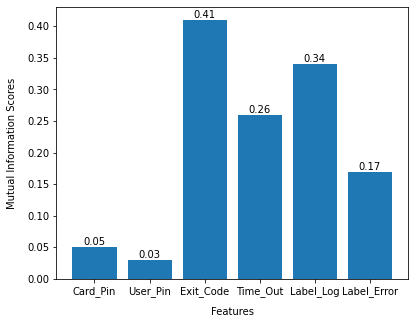

In [152]:
fig, ax1 = plt.subplots(figsize=(6.3, 5))

ax1.bar(['Card_Pin', 'User_Pin', 'Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error'], fs.scores_)

for container in ax1.containers:
    ax1.bar_label(container)
    
ax1.set_xlabel("Features", labelpad=10)
ax1.set_ylabel("Mutual Information Scores", labelpad=10)

plt.show()

### Cramer's V for Categorical vs Categorical data

In [145]:
cramers_v_card_pin = cramers_v(X_train['Card_Pin'].values.flatten(), y_train.values.flatten())
cramers_v_card_pin

0.07

In [146]:
cramers_v_user_pin = cramers_v(X_train['User_Pin'].values.flatten(), y_train.values.flatten())
cramers_v_user_pin

0.02

In [147]:
cramers_v_label_log = cramers_v(X_train['Label_Log'].values.flatten(), y_train.values.flatten())
cramers_v_label_log

0.46

In [148]:
cramers_v_label_error = cramers_v(X_train['Label_Error'].values.flatten(), y_train.values.flatten())
cramers_v_label_error

0.19

In [149]:
cramers_v_time_out = cramers_v(X_train['Time_Out'].values.flatten(), y_train.values.flatten())
cramers_v_time_out

0.28

In [150]:
cramers_v_exit_code = cramers_v(X_train['Exit_Code'].values.flatten(), y_train.values.flatten())
cramers_v_exit_code

0.39

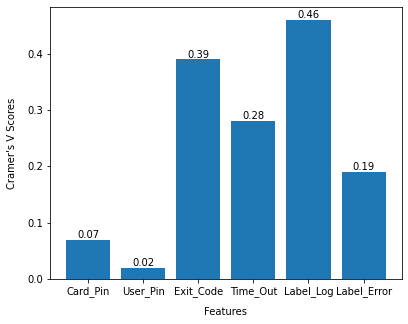

In [153]:
fig, ax1 = plt.subplots(figsize=(6.3, 5))

ax1.bar(['Card_Pin', 'User_Pin', 'Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error'], 
        [cramers_v_card_pin, cramers_v_user_pin, cramers_v_exit_code, cramers_v_time_out, cramers_v_label_log, cramers_v_label_error])

for container in ax1.containers:
    ax1.bar_label(container)

ax1.set_xlabel("Features", labelpad=10)
ax1.set_ylabel("Cramer's V Scores", labelpad=10)

plt.show()

### Card and User PIN dropped as they are not good predictors of fault type

In [114]:
X = X.drop(columns=['Card_Pin', 'User_Pin'])

## Training supervised model for fault type predicition - Naive Classifier

In [100]:
naive_model_nop = DummyClassifier(strategy='constant', constant='NOP').fit(X_train, y_train.values.flatten())

filePath = "%s/Naive Models/naive_model_nop.sav" %(path)
os.makedirs(os.path.dirname(filePath), exist_ok=True)
fileObj = open(filePath, 'wb')
pickle.dump(naive_model_nop, fileObj)
fileObj.close()

In [101]:
naive_model_flp = DummyClassifier(strategy='constant', constant='FLP').fit(X_train, y_train.values.flatten())

filePath = "%s/Naive Models/naive_model_flp.sav" %(path)
os.makedirs(os.path.dirname(filePath), exist_ok=True)
fileObj = open(filePath, 'wb')
pickle.dump(naive_model_flp, fileObj)
fileObj.close()

In [102]:
naive_model_none = DummyClassifier(strategy='constant', constant='NONE').fit(X_train, y_train.values.flatten())

filePath = "%s/Naive Models/naive_model_none.sav" %(path)
os.makedirs(os.path.dirname(filePath), exist_ok=True)
fileObj = open(filePath, 'wb')
pickle.dump(naive_model_none, fileObj)
fileObj.close()

## Training supervised model for fault type predicition - KNN

In [87]:
t0 = time()
knn = KNeighborsClassifier(n_neighbors = int(math.sqrt(X_train.shape[0]))).fit(X_train, y_train.values.flatten())
knn_fit_time = time() - t0

In [88]:
print("knn_fit_time: %d" %(knn_fit_time))

knn_fit_time: 0


### KNN - Nested CV

In [89]:
cv_outer_knn = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [90]:
accuracy_scores_knn=[]
precision_scores_knn=[]
recall_scores_knn=[]
f1_scores_knn=[]

In [91]:
t0 = time()
count = 0
for train_ix, test_ix in cv_outer_knn.split(X, y):
    print(train_ix)
    print(test_ix)
    X_train_cv_knn, X_test_cv_knn = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train_cv_knn, y_test_cv_knn = y.iloc[train_ix], y.iloc[test_ix]
    
    cv_inner_knn = KFold(n_splits=5, shuffle=True, random_state=1)
    
    knn_kfold = KNeighborsClassifier(n_jobs=1)
    
    n_neighbors = [int(x) for x in np.linspace(start = 10, stop = 700, num = 20)]
    
    weights = ['uniform', 'distance']
    
    algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
    
    leaf_sizes = [30, 60, 90, 150, 200]
    
    random_grid = {'n_neighbors': n_neighbors,
                   'weights': weights,
                   'algorithm': algorithms,
                   'leaf_size': leaf_sizes}
    
    knn_random_kfold = RandomizedSearchCV(estimator=knn_kfold, param_distributions=random_grid, n_iter=5, cv=cv_inner_knn, 
                                   verbose=2, random_state=42, n_jobs = 2)
    
    result_knn = knn_random_kfold.fit(X_train_cv_knn, y_train_cv_knn.values.flatten())
    
    knn_random_kfold_best = knn_random_kfold.best_estimator_
    
    filePath = "%s/KNN Models/KFold Models/kfold_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(knn_random_kfold_best, fileObj)
    fileObj.close()
    
    ypred_knn_random_kfold = knn_random_kfold_best.predict(X_test_cv_knn)
    accuracy_this_fold_knn = accuracy_score(y_test_cv_knn, ypred_knn_random_kfold)
    precision_this_fold_knn = precision_score(y_test_cv_knn, ypred_knn_random_kfold, average='weighted')
    recall_this_fold_knn = recall_score(y_test_cv_knn, ypred_knn_random_kfold, average='weighted')
    f1_score_this_fold_knn = f1_score(y_test_cv_knn, ypred_knn_random_kfold, average='weighted')
    
    print("Best Score: %.3f, with parameters: %s" %(result_knn.best_score_, result_knn.best_params_))    
    
    print("Accuracy: %.3f" %(accuracy_this_fold_knn))
    print("Precision: %.3f" %(precision_this_fold_knn))
    print("Recall: %.3f" %(recall_this_fold_knn))
    print("F1 Score: %.3f" %(f1_score_this_fold_knn))
    
    accuracy_scores_knn.append(accuracy_this_fold_knn)
    precision_scores_knn.append(precision_this_fold_knn)
    recall_scores_knn.append(recall_this_fold_knn)
    f1_scores_knn.append(f1_score_this_fold_knn)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")

nested_cv_time_knn = time() - t0

[     0      1      2 ... 599990 599991 599993]
[    28     32     43 ... 599974 599985 599992]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.534, with parameters: {'weights': 'uniform', 'n_neighbors': 80, 'leaf_size': 60, 'algorithm': 'auto'}
Accuracy: 0.534
Precision: 0.764
Recall: 0.534
F1 Score: 0.448
-------------------------------------------------------------------------------------------------------------------
[     0      1      2 ... 599991 599992 599993]
[     9     11     38 ... 599969 599978 599990]
Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Score: 0.534, with parameters: {'weights': 'uniform', 'n_neighbors': 60, 'leaf_size': 200, 'algorithm': 'auto'}
Accuracy: 0.535
Precision: 0.473
Recall: 0.535
F1 Score: 0.448
-------------------------------------------------------------------------------------------------------------------
[     0      1      2 ... 599991 599992 599993]
[     5     12     15 ... 599951 599965 599972]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.534, with parameters: {'weights': 'uniform', 'n_neighbors': 100, 'leaf_size': 150, 'algorithm': 'auto'}
Accuracy: 0.534
Precision: 0.765
Recall: 0.534
F1 Score: 0.447
-------------------------------------------------------------------------------------------------------------------
[     0      4      5 ... 599991 599992 599993]
[     1      2      3 ... 599956 599981 599984]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.534, with parameters: {'weights': 'uniform', 'n_neighbors': 100, 'leaf_size': 150

C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Score: 0.534, with parameters: {'weights': 'uniform', 'n_neighbors': 60, 'leaf_size': 200, 'algorithm': 'auto'}
Accuracy: 0.532
Precision: 0.472
Recall: 0.532
F1 Score: 0.445
-------------------------------------------------------------------------------------------------------------------
[     1      2      3 ... 599991 599992 599993]
[     0      4     14 ... 599980 599988 599989]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.534, with parameters: {'weights': 'uniform', 'n_neighbors': 100, 'leaf_size': 150, 'algorithm': 'auto'}
Accuracy: 0.534
Precision: 0.747
Recall: 0.534
F1 Score: 0.448
-------------------------------------------------------------------------------------------------------------------
[     0      1      2 ... 599991 599992 599993]
[     7     13     22 ... 599966 599968 599983]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.534, with parameters: {'weights': 'uniform', 'n_neighbors': 100, 'leaf_size': 150

In [92]:
print("nested_cv_time_knn: %d" %(nested_cv_time_knn))

nested_cv_time_knn: 34577


In [95]:
filePathAcc = "%s/KNN Models/KFold Models/kfold_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/KNN Models/KFold Models/kfold_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/KNN Models/KFold Models/kfold_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/KNN Models/KFold Models/kfold_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_knn, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_knn, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_knn, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_knn, filehandle)

In [38]:
filePathAcc = "%s/KNN Models/KFold Models/kfold_accuracy_scores.txt" %(path)

filePathPrec = "%s/KNN Models/KFold Models/kfold_precision_scores.txt" %(path)

filePathRecall = "%s/KNN Models/KFold Models/kfold_recall_scores.txt" %(path)

filePathF1 = "%s/KNN Models/KFold Models/kfold_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_knn = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_knn = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_knn = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_knn = data

In [39]:
accuracy_scores_knn = np.asarray(accuracy_scores_knn)
precision_scores_knn = np.asarray(precision_scores_knn)
recall_scores_knn = np.asarray(recall_scores_knn)
f1_scores_knn = np.asarray(f1_scores_knn)

print("K-NN K-fold Mean Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_knn.mean(), 
                                                                 (accuracy_scores_knn.std())))

print("K-NN K-fold Mean Precision: %.3f, with deviation of: %.3f" %(precision_scores_knn.mean(), 
                                                                  precision_scores_knn.std()))

print("K-NN K-fold Mean Recall: %.3f, with deviation of: %.3f" %(recall_scores_knn.mean(), 
                                                               recall_scores_knn.std()))

print("K-NN K-fold Mean F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_knn.mean(), 
                                                                 f1_scores_knn.std()))

K-NN K-fold Mean Accuracy: 0.534, with deviation of: 0.001
K-NN K-fold Mean Precision: 0.706, with deviation of: 0.117
K-NN K-fold Mean Recall: 0.534, with deviation of: 0.001
K-NN K-fold Mean F1 Score: 0.447, with deviation of: 0.001


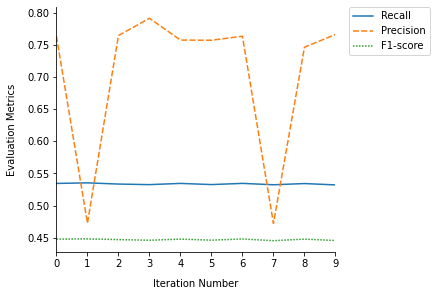

In [154]:
knn_kfold_plot_data = pd.DataFrame({
    'Recall': recall_scores_knn,
    'Precision': precision_scores_knn,
    'F1-score': f1_scores_knn
})
fig, ax1 = plt.subplots(figsize=(5, 4.5))
knn_kfold_lineplot = sns.lineplot(data=knn_kfold_plot_data, ax=ax1)
ax1.set(xlim=(0, 9))
ax1.set_xlabel("Iteration Number", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
sns.despine(fig)

### KNN - Testing model with different percentages of train and test data

In [30]:
accuracy_scores_tt_knn=[]
precision_scores_tt_knn=[]
recall_scores_tt_knn=[]
f1_scores_tt_knn=[]

In [ ]:
t0 = time()
count = 0
for ratio in [(0.9,0.1), (0.8,0.2), (0.75,0.25), (0.6,0.4), (0.5,0.5), (0.4,0.6), (0.3, 0.7), (0.15, 0.85)]:
    print("Train: %.2f and Test: %.2f" %(ratio[0], ratio[1]))
    
    X_train_tt_knn, X_test_tt_knn, y_train_tt_knn, y_test_tt_knn = train_test_split(X, y, train_size=ratio[0], random_state = 1)
    
    knn_tt = KNeighborsClassifier(n_jobs=2, 
                                 weights='distance',
                                 n_neighbors=554,
                                 leaf_size=60)\
    .fit(X_train_tt_knn, y_train_tt_knn.values.flatten())
    
    filePath = "%s/KNN Models/TT Models/tt_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(knn_tt, fileObj)
    fileObj.close()
    
    ypred_knn_tt = knn_tt.predict(X_test_tt_knn)
    
    accuracy_tt_knn = accuracy_score(y_test_tt_knn, ypred_knn_tt)
    precision_tt_knn = precision_score(y_test_tt_knn, ypred_knn_tt, average='weighted')
    recall_tt_knn = recall_score(y_test_tt_knn, ypred_knn_tt, average='weighted')
    f1_score_tt_knn = f1_score(y_test_tt_knn, ypred_knn_tt, average='weighted')   
    
    print("Accuracy: %.3f" %(accuracy_tt_knn))
    print("Precision: %.3f" %(precision_tt_knn))
    print("Recall: %.3f" %(recall_tt_knn))
    print("F1 Score: %.3f" %(f1_score_tt_knn))
    
    accuracy_scores_tt_knn.append(accuracy_tt_knn)
    precision_scores_tt_knn.append(precision_tt_knn)
    recall_scores_tt_knn.append(recall_tt_knn)
    f1_scores_tt_knn.append(f1_score_tt_knn)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")
    
train_test_time_knn = time() - t0

Train: 0.90 and Test: 0.10
Accuracy: 0.733
Precision: 0.850
Recall: 0.733
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
Train: 0.80 and Test: 0.20
Accuracy: 0.731
Precision: 0.849
Recall: 0.731
F1 Score: 0.735
-------------------------------------------------------------------------------------------------------------------
Train: 0.75 and Test: 0.25
Accuracy: 0.731
Precision: 0.849
Recall: 0.731
F1 Score: 0.736
-------------------------------------------------------------------------------------------------------------------
Train: 0.60 and Test: 0.40
Accuracy: 0.731
Precision: 0.849
Recall: 0.731
F1 Score: 0.736
-------------------------------------------------------------------------------------------------------------------
Train: 0.50 and Test: 0.50


In [ ]:
print("train_test_time_knn: %d" %(train_test_time_knn))

In [ ]:
filePathAcc = "%s/KNN Models/TT Models/tt_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/KNN Models/TT Models/tt_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/KNN Models/TT Models/tt_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/KNN Models/TT Models/tt_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_tt_knn, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_tt_knn, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_tt_knn, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_tt_knn, filehandle)

In [41]:
filePathAcc = "%s/KNN Models/TT Models/tt_accuracy_scores.txt" %(path)

filePathPrec = "%s/KNN Models/TT Models/tt_precision_scores.txt" %(path)

filePathRecall = "%s/KNN Models/TT Models/tt_recall_scores.txt" %(path)

filePathF1 = "%s/KNN Models/TT Models/tt_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_tt_knn = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_tt_knn = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_tt_knn = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_tt_knn = data

In [42]:
accuracy_scores_tt_knn = np.asarray(accuracy_scores_tt_knn)
precision_scores_tt_knn = np.asarray(precision_scores_tt_knn)
recall_scores_tt_knn = np.asarray(recall_scores_tt_knn)
f1_scores_tt_knn = np.asarray(f1_scores_tt_knn)

print("K-NN TT Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_tt_knn.mean(), 
                                                                 (accuracy_scores_tt_knn.std())))

print("K-NN TT Precision: %.3f, with deviation of: %.3f" %(precision_scores_tt_knn.mean(), 
                                                                  precision_scores_tt_knn.std()))

print("K-NN TT Recall: %.3f, with deviation of: %.3f" %(recall_scores_tt_knn.mean(), 
                                                               recall_scores_tt_knn.std()))

print("K-NN TT F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_tt_knn.mean(), 
                                                                 f1_scores_tt_knn.std()))

K-NN TT Accuracy: 0.731, with deviation of: 0.001
K-NN TT Precision: 0.849, with deviation of: 0.000
K-NN TT Recall: 0.731, with deviation of: 0.001
K-NN TT F1 Score: 0.736, with deviation of: 0.001


C:\Users\aakas\AppData\Local\Temp\ipykernel_7836\1690785231.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  knn_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)",


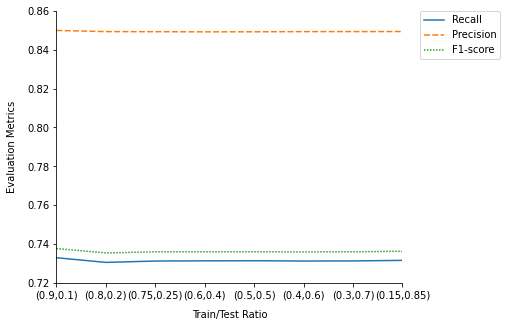

In [155]:
knn_train_test_plot_data = pd.DataFrame({
    'Recall': recall_scores_tt_knn,
    'Precision': precision_scores_tt_knn,
    'F1-score': f1_scores_tt_knn
})
fig, ax1 = plt.subplots(figsize=(6.2, 5))
knn_tt_lineplot = sns.lineplot(data=knn_train_test_plot_data, ax=ax1)
ax1.set(xlim=(0, 7))
ax1.set(ylim=(0.72, 0.86))
ax1.set_xlabel("Train/Test Ratio", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
knn_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)", 
                   "(0.4,0.6)", "(0.3,0.7)", "(0.15,0.85)"])
sns.despine(fig)

## Training supervised model for fault type predicition - Random Forest

In [118]:
t0 = time()
rfc = RandomForestClassifier(n_estimators=25, min_samples_split=20, min_samples_leaf=50,
                             max_features='auto', max_depth=30, bootstrap=False, 
                             random_state=0, criterion="entropy").fit(X_train, y_train.values.flatten())
rf_fit_time = time() - t0

In [119]:
print("rf_fit_time: %d" %(rf_fit_time))

rf_fit_time: 2


### Random Forest - Nested CV

In [37]:
cv_outer = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [38]:
accuracy_scores=[]
precision_scores=[]
recall_scores=[]
f1_scores=[]

In [39]:
t0 = time()
count = 0
for train_ix, test_ix in cv_outer.split(X, y):
    print(train_ix)
    print(test_ix)
    X_train_cv, X_test_cv = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train_cv, y_test_cv = y.iloc[train_ix], y.iloc[test_ix]
    
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    
    rfc_kfold = RandomForestClassifier(random_state=0, criterion="entropy")
    
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(2, 20, num = 11)]
    max_depth.append(None)
    min_samples_split = [10, 20, 50, 70, 100]
    min_samples_leaf = [100, 200, 300, 400, 500]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    rf_random_kfold = RandomizedSearchCV(estimator=rfc_kfold, param_distributions=random_grid, n_iter=5, cv=cv_inner, 
                                   verbose=2, random_state=42, n_jobs = 2)
    
    result = rf_random_kfold.fit(X_train_cv, y_train_cv.values.flatten())
    
    rfc_random_kfold_best = rf_random_kfold.best_estimator_
    
    filePath = "%s/Random Forest Models/KFold Models/kfold_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(rfc_random_kfold_best, fileObj)
    fileObj.close()
    
    ypred_rfc_random_kfold = rfc_random_kfold_best.predict(X_test_cv)
    accuracy_this_fold = accuracy_score(y_test_cv, ypred_rfc_random_kfold)
    precision_this_fold = precision_score(y_test_cv, ypred_rfc_random_kfold, average='weighted')
    recall_this_fold = recall_score(y_test_cv, ypred_rfc_random_kfold, average='weighted')
    f1_score_this_fold = f1_score(y_test_cv, ypred_rfc_random_kfold, average='weighted')
    
    print("Best Score: %.3f, with parameters: %s" %(result.best_score_, result.best_params_))    
    
    print("Accuracy: %.3f" %(accuracy_this_fold))
    print("Precision: %.3f" %(precision_this_fold))
    print("Recall: %.3f" %(recall_this_fold))
    print("F1 Score: %.3f" %(f1_score_this_fold))
    
    accuracy_scores.append(accuracy_this_fold)
    precision_scores.append(precision_this_fold)
    recall_scores.append(recall_this_fold)
    f1_scores.append(f1_score_this_fold)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")

nested_cv_time = time() - t0

[     0      1      2 ... 599990 599991 599993]
[    28     32     43 ... 599974 599985 599992]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.733, with parameters: {'n_estimators': 150, 'min_samples_split': 50, 'min_samples_leaf': 200, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Accuracy: 0.734
Precision: 0.852
Recall: 0.734
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
[     0      1      2 ... 599991 599992 599993]
[     9     11     38 ... 599969 599978 599990]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.733, with parameters: {'n_estimators': 150, 'min_samples_split': 50, 'min_samples_leaf': 200, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Accuracy: 0.734
Precision: 0.852
Recall: 0.734
F1 Score: 0.739
--------------------------------------------------------------------------------------------------------

In [60]:
print("nested_cv_time: %d" %(nested_cv_time))

nested_cv_time: 1325


In [61]:
filePathAcc = "%s/Random Forest Models/KFold Models/kfold_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/Random Forest Models/KFold Models/kfold_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/Random Forest Models/KFold Models/kfold_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/Random Forest Models/KFold Models/kfold_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores, filehandle)

In [44]:
filePathAcc = "%s/Random Forest Models/KFold Models/kfold_accuracy_scores.txt" %(path)

filePathPrec = "%s/Random Forest Models/KFold Models/kfold_precision_scores.txt" %(path)

filePathRecall = "%s/Random Forest Models/KFold Models/kfold_recall_scores.txt" %(path)

filePathF1 = "%s/Random Forest Models/KFold Models/kfold_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores = data

In [45]:
accuracy_scores = np.asarray(accuracy_scores)
precision_scores = np.asarray(precision_scores)
recall_scores = np.asarray(recall_scores)
f1_scores = np.asarray(f1_scores)

print("RF K-fold Mean Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores.mean(), 
                                                                 (accuracy_scores.std())))

print("RF K-fold Mean Precision: %.3f, with deviation of: %.3f" %(precision_scores.mean(), 
                                                                  precision_scores.std()))

print("RF K-fold Mean Recall: %.3f, with deviation of: %.3f" %(recall_scores.mean(), 
                                                               recall_scores.std()))

print("RF K-fold Mean F1 Score: %.3f, with deviation of: %.3f" %(f1_scores.mean(), 
                                                                 f1_scores.std()))

RF K-fold Mean Accuracy: 0.733, with deviation of: 0.002
RF K-fold Mean Precision: 0.852, with deviation of: 0.001
RF K-fold Mean Recall: 0.733, with deviation of: 0.002
RF K-fold Mean F1 Score: 0.738, with deviation of: 0.002


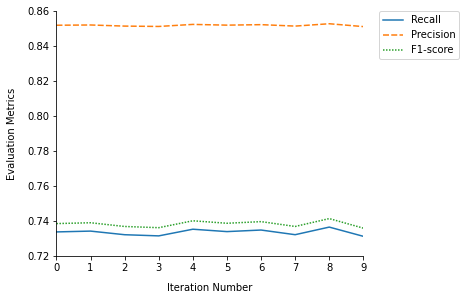

In [156]:
rf_kfold_plot_data = pd.DataFrame({
    'Recall': recall_scores,
    'Precision': precision_scores,
    'F1-score': f1_scores
})
fig, ax1 = plt.subplots(figsize=(5.5, 4.5))
rf_kfold_lineplot = sns.lineplot(data=rf_kfold_plot_data, ax=ax1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlabel("Iteration Number", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
ax1.set(xlim=(0, 9))
ax1.set(ylim=(0.72, 0.86))

sns.despine(fig)

### Random Forest - Testing model with different percentages of train and test data

In [40]:
accuracy_scores_tt=[]
precision_scores_tt=[]
recall_scores_tt=[]
f1_scores_tt=[]

In [41]:
t0 = time()
count = 0
for ratio in [(0.9,0.1), (0.8,0.2), (0.75,0.25), (0.6,0.4), (0.5,0.5), (0.4,0.6), (0.3, 0.7), (0.15, 0.85)]:
    print("Train: %.2f and Test: %.2f" %(ratio[0], ratio[1]))
    
    X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(X, y, train_size=ratio[0], random_state = 1)
    
    rfc_tt = RandomForestClassifier(n_estimators=50, min_samples_split=50, min_samples_leaf=200,
                             max_features='auto', max_depth=15, bootstrap=False, 
                             random_state=0, criterion="entropy")\
    .fit(X_train_tt, y_train_tt.values.flatten())
    
    filePath = "%s/Random Forest Models/TT Models/tt_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(rfc_tt, fileObj)
    fileObj.close()
    
    ypred_rfc_tt = rfc_tt.predict(X_test_tt)
    
    accuracy_tt = accuracy_score(y_test_tt, ypred_rfc_tt)
    precision_tt = precision_score(y_test_tt, ypred_rfc_tt, average='weighted')
    recall_tt = recall_score(y_test_tt, ypred_rfc_tt, average='weighted')
    f1_score_tt = f1_score(y_test_tt, ypred_rfc_tt, average='weighted')   
    
    print("Accuracy: %.3f" %(accuracy_tt))
    print("Precision: %.3f" %(precision_tt))
    print("Recall: %.3f" %(recall_tt))
    print("F1 Score: %.3f" %(f1_score_tt))
    
    accuracy_scores_tt.append(accuracy_tt)
    precision_scores_tt.append(precision_tt)
    recall_scores_tt.append(recall_tt)
    f1_scores_tt.append(f1_score_tt)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")
    
train_test_time = time() - t0

Train: 0.90 and Test: 0.10
Accuracy: 0.732
Precision: 0.852
Recall: 0.732
F1 Score: 0.737
-------------------------------------------------------------------------------------------------------------------
Train: 0.80 and Test: 0.20
Accuracy: 0.733
Precision: 0.852
Recall: 0.733
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
Train: 0.75 and Test: 0.25
Accuracy: 0.733
Precision: 0.852
Recall: 0.733
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
Train: 0.60 and Test: 0.40
Accuracy: 0.733
Precision: 0.852
Recall: 0.733
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
Train: 0.50 and Test: 0.50
Accuracy: 0.733
Precision: 0.852
Recall: 0.733
F1 Score: 0.738
--------------------------------------------------------------------------------------

In [64]:
print("train_test_time: %d" %(train_test_time))

train_test_time: 180


In [65]:
filePathAcc = "%s/Random Forest Models/TT Models/tt_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/Random Forest Models/TT Models/tt_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/Random Forest Models/TT Models/tt_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/Random Forest Models/TT Models/tt_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_tt, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_tt, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_tt, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_tt, filehandle)

In [47]:
filePathAcc = "%s/Random Forest Models/TT Models/tt_accuracy_scores.txt" %(path)

filePathPrec = "%s/Random Forest Models/TT Models/tt_precision_scores.txt" %(path)

filePathRecall = "%s/Random Forest Models/TT Models/tt_recall_scores.txt" %(path)

filePathF1 = "%s/Random Forest Models/TT Models/tt_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_tt = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_tt = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_tt = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_tt = data

In [48]:
accuracy_scores_tt = np.asarray(accuracy_scores_tt)
precision_scores_tt = np.asarray(precision_scores_tt)
recall_scores_tt = np.asarray(recall_scores_tt)
f1_scores_tt = np.asarray(f1_scores_tt)

print("RF TT Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_tt.mean(), 
                                                                 (accuracy_scores_tt.std())))

print("RF TT Precision: %.3f, with deviation of: %.3f" %(precision_scores_tt.mean(), 
                                                                  precision_scores_tt.std()))

print("RF TT Recall: %.3f, with deviation of: %.3f" %(recall_scores_tt.mean(), 
                                                               recall_scores_tt.std()))

print("RF TT F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_tt.mean(), 
                                                                 f1_scores_tt.std()))

RF TT Accuracy: 0.733, with deviation of: 0.000
RF TT Precision: 0.852, with deviation of: 0.000
RF TT Recall: 0.733, with deviation of: 0.000
RF TT F1 Score: 0.738, with deviation of: 0.000


C:\Users\aakas\AppData\Local\Temp\ipykernel_7836\3622772838.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  rf_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)",


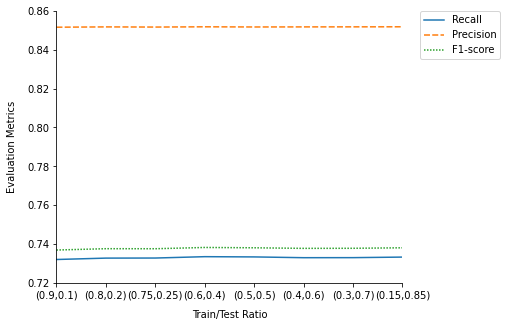

In [157]:
rf_train_test_plot_data = pd.DataFrame({
    'Recall': recall_scores_tt,
    'Precision': precision_scores_tt,
    'F1-score': f1_scores_tt
})
fig, ax1 = plt.subplots(figsize=(6.2, 5))
rf_tt_lineplot = sns.lineplot(data=rf_train_test_plot_data, ax=ax1)
ax1.set(xlim=(0, 7))
ax1.set(ylim=(0.72, 0.86))
ax1.set_xlabel("Train/Test Ratio", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
rf_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)", 
                   "(0.4,0.6)", "(0.3,0.7)", "(0.15,0.85)"])
sns.despine(fig)

## Training supervised model for fault type predicition - XGB

In [1156]:
y_train_2 = y_train.copy()
y_train_2.Fault_Type = pd.Categorical(y_train_2.Fault_Type)
y_train_2['Fault_Type_Codes'] = y_train_2.Fault_Type.cat.codes
y_train_2 = y_train_2.drop(columns=['Fault_Type'])
y_train_2 = y_train_2.rename(columns={"Fault_Type_Codes": "Fault_Type"})

In [1157]:
t0 = time()
xgb = XGBClassifier(booster='dart', objective='multi:softmax', eval_metric='merror',
                   tree_method='auto', grow_policy='depthwise', min_child_weight=5,
                   max_depth=5, reg_alpha=2).fit(X_train, y_train_2.values.flatten())
xgb_fit_time = time() - t0

[19:04:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=5
[19:04:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[19:04:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[19:04:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:04:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[19:04:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[19:04:34] INFO: C:/

[19:04:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[19:04:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=4
[19:04:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=5
[19:04:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:04:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:04:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[19:04:36] INFO: C:/U

[19:04:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[19:04:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[19:04:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[19:04:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:04:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[19:04:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[19:04:39] INFO: C:/U

[19:04:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[19:04:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[19:04:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[19:04:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:04:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[19:04:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[19:04:42] INFO: C:/U

[19:04:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[19:04:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:04:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=5
[19:04:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:04:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[19:04:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:04:46] INFO: C:/U

[19:04:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[19:04:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:04:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[19:04:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:04:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=5
[19:04:51] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:04:51] INFO: C:/U

[19:04:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[19:04:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:04:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[19:04:56] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:04:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[19:04:57] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:04:57] INFO: C:/U

[19:05:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:05:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:05:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[19:05:03] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:05:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[19:05:04] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:05:04] INFO: C:/U

In [1158]:
print("xgb_fit_time: %d" %(xgb_fit_time))

xgb_fit_time: 32


### Nested CV

In [42]:
cv_outer_xgb = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [43]:
accuracy_scores_nested_cv_xgb=[]
precision_scores_nested_cv_xgb=[]
recall_scores_nested_cv_xgb=[]
f1_scores_nested_cv_xgb=[]

In [44]:
t0 = time()
count = 0
for train_ix_xgb, test_ix_xgb in cv_outer_xgb.split(X, y):
    X_train_cv_xgb, X_test_cv_xgb = X.iloc[train_ix_xgb, :], X.iloc[test_ix_xgb, :]
    y_train_cv_xgb_raw, y_test_cv_xgb_raw = y.iloc[train_ix_xgb], y.iloc[test_ix_xgb]
    
    y_train_cv_xgb = y_train_cv_xgb_raw.copy()
    y_train_cv_xgb.Fault_Type = pd.Categorical(y_train_cv_xgb.Fault_Type)
    y_train_cv_xgb['Fault_Type_Codes'] = y_train_cv_xgb.Fault_Type.cat.codes
    y_train_cv_xgb = y_train_cv_xgb.drop(columns=['Fault_Type'])
    y_train_cv_xgb = y_train_cv_xgb.rename(columns={"Fault_Type_Codes": "Fault_Type"})
    print("Encoded Train Labels")
    
    y_test_cv_xgb = y_test_cv_xgb_raw.copy()
    y_test_cv_xgb.Fault_Type = pd.Categorical(y_test_cv_xgb.Fault_Type)
    y_test_cv_xgb['Fault_Type_Codes'] = y_test_cv_xgb.Fault_Type.cat.codes
    y_test_cv_xgb = y_test_cv_xgb.drop(columns=['Fault_Type'])
    y_test_cv_xgb = y_test_cv_xgb.rename(columns={"Fault_Type_Codes": "Fault_Type"})
    print("Encoded Test Labels")
    
    cv_inner_xgb = KFold(n_splits=5, shuffle=True, random_state=1)
    
    xgb_kfold = XGBClassifier(enable_categorical=True)
    
    boosters = ['gbtree', 'dart']
    objectives = ['multi:softmax']
    eval_metrics = ['merror']
    tree_methods = ['approx', 'hist']
    grow_policies = ['depthwise', 'lossguide']
    min_child_weights = [2, 5, 10]
    max_depths = [int(x) for x in np.linspace(2, 20, num = 11)]
    reg_alphas = [int(x) for x in np.linspace(2, 10, num = 6)]
    
    random_grid_xgb = {'booster': boosters,
                   'objective': objectives,
                   'eval_metric': eval_metrics,
                   'tree_method': tree_methods,
                   'grow_policy': grow_policies,
                   'min_child_weight': min_child_weights,
                   'max_depth': max_depths,
                   'reg_alpha': reg_alphas
                  }
    
    xgb_random_kfold = RandomizedSearchCV(estimator=xgb_kfold, param_distributions=random_grid_xgb, n_iter=5, cv=cv_inner_xgb, 
                                   verbose=2, random_state=42, n_jobs = 2)
    
    result_xgb = xgb_random_kfold.fit(X_train_cv_xgb, y_train_cv_xgb.values.flatten())
    
    xgb_random_kfold_best = xgb_random_kfold.best_estimator_
    
    filePath = "%s/XGB Models/KFold Models/kfold_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(xgb_random_kfold_best, fileObj)
    fileObj.close()
    
    ypred_xgb_random_kfold = xgb_random_kfold_best.predict(X_test_cv_xgb)
    accuracy_this_fold = accuracy_score(y_test_cv_xgb, ypred_xgb_random_kfold)
    precision_this_fold = precision_score(y_test_cv_xgb, ypred_xgb_random_kfold, average='weighted')
    recall_this_fold = recall_score(y_test_cv_xgb, ypred_xgb_random_kfold, average='weighted')
    f1_score_this_fold = f1_score(y_test_cv_xgb, ypred_xgb_random_kfold, average='weighted')
    
    print("Best Score: %.3f, with parameters: %s" %(result_xgb.best_score_, result_xgb.best_params_))    
    
    print("Accuracy: %.3f" %(accuracy_this_fold))
    print("Precision: %.3f" %(precision_this_fold))
    print("Recall: %.3f" %(recall_this_fold))
    print("F1 Score: %.3f" %(f1_score_this_fold))
    
    accuracy_scores_nested_cv_xgb.append(accuracy_this_fold)
    precision_scores_nested_cv_xgb.append(precision_this_fold)
    recall_scores_nested_cv_xgb.append(recall_this_fold)
    f1_scores_nested_cv_xgb.append(f1_score_this_fold)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")
    
xgb_random_kfold_time = time() - t0

Encoded Train Labels
Encoded Test Labels
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.733, with parameters: {'tree_method': 'approx', 'reg_alpha': 10, 'objective': 'multi:softmax', 'min_child_weight': 2, 'max_depth': 18, 'grow_policy': 'depthwise', 'eval_metric': 'merror', 'booster': 'dart'}
Accuracy: 0.734
Precision: 0.852
Recall: 0.734
F1 Score: 0.739
-------------------------------------------------------------------------------------------------------------------
Encoded Train Labels
Encoded Test Labels
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.733, with parameters: {'tree_method': 'approx', 'reg_alpha': 10, 'objective': 'multi:softmax', 'min_child_weight': 2, 'max_depth': 18, 'grow_policy': 'depthwise', 'eval_metric': 'merror', 'booster': 'dart'}
Accuracy: 0.734
Precision: 0.852
Recall: 0.734
F1 Score: 0.739
------------------------------------------------------------------------------------------------------------------

In [66]:
print("xgb_random_kfold_time: %d" %(xgb_random_kfold_time))

xgb_random_kfold_time: 61440


In [67]:
filePathAcc = "%s/XGB Models/KFold Models/kfold_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/XGB Models/KFold Models/kfold_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/XGB Models/KFold Models/kfold_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/XGB Models/KFold Models/kfold_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_nested_cv_xgb, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_nested_cv_xgb, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_nested_cv_xgb, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_nested_cv_xgb, filehandle)

In [50]:
filePathAcc = "%s/XGB Models/KFold Models/kfold_accuracy_scores.txt" %(path)

filePathPrec = "%s/XGB Models/KFold Models/kfold_precision_scores.txt" %(path)

filePathRecall = "%s/XGB Models/KFold Models/kfold_recall_scores.txt" %(path)

filePathF1 = "%s/XGB Models/KFold Models/kfold_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_nested_cv_xgb = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_nested_cv_xgb = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_nested_cv_xgb = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_nested_cv_xgb = data

In [51]:
accuracy_scores_nested_cv_xgb = np.asarray(accuracy_scores_nested_cv_xgb)
precision_scores_nested_cv_xgb = np.asarray(precision_scores_nested_cv_xgb)
recall_scores_nested_cv_xgb = np.asarray(recall_scores_nested_cv_xgb)
f1_scores_nested_cv_xgb = np.asarray(f1_scores_nested_cv_xgb)

print("XGB K-fold Mean Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_nested_cv_xgb.mean(), 
                                                                 (accuracy_scores_nested_cv_xgb.std())))

print("XGB K-fold Mean Precision: %.3f, with deviation of: %.3f" %(precision_scores_nested_cv_xgb.mean(), 
                                                                  precision_scores_nested_cv_xgb.std()))

print("XGB K-fold Mean Recall: %.3f, with deviation of: %.3f" %(recall_scores_nested_cv_xgb.mean(), 
                                                               recall_scores_nested_cv_xgb.std()))

print("XGB K-fold Mean F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_nested_cv_xgb.mean(), 
                                                                 f1_scores_nested_cv_xgb.std()))

XGB K-fold Mean Accuracy: 0.734, with deviation of: 0.002
XGB K-fold Mean Precision: 0.852, with deviation of: 0.001
XGB K-fold Mean Recall: 0.734, with deviation of: 0.002
XGB K-fold Mean F1 Score: 0.738, with deviation of: 0.002


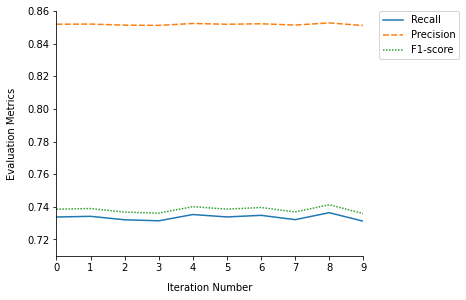

In [158]:
xgb_kfold_plot_data = pd.DataFrame({
    'Recall': recall_scores_nested_cv_xgb,
    'Precision': precision_scores_nested_cv_xgb,
    'F1-score': f1_scores_nested_cv_xgb
})
fig, ax1 = plt.subplots(figsize=(5.5, 4.5))
sns.lineplot(data=xgb_kfold_plot_data, ax=ax1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set(xlim=(0, 9))
ax1.set(ylim=(0.71, 0.86))
ax1.set_xlabel("Iteration Number", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
sns.despine(fig)

### XGB - Testing model with different percentages of train and test data

In [45]:
accuracy_scores_tt_xgb=[]
precision_scores_tt_xgb=[]
recall_scores_tt_xgb=[]
f1_scores_tt_xgb=[]

In [46]:
t0 = time()
count = 0
for ratio in [(0.9,0.1), (0.8,0.2), (0.75,0.25), (0.6,0.4), (0.5,0.5), (0.4,0.6), (0.3, 0.7), (0.15, 0.85)]:
    print("Train: %.2f and Test: %.2f" %(ratio[0], ratio[1]))
    
    X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(X, y, train_size=ratio[0], random_state = 1)
    
    y_train_tt.Fault_Type = pd.Categorical(y_train_tt.Fault_Type)
    y_train_tt['Fault_Type_Codes'] = y_train_tt.Fault_Type.cat.codes
    y_train_tt = y_train_tt.drop(columns=['Fault_Type'])
    y_train_tt = y_train_tt.rename(columns={"Fault_Type_Codes": "Fault_Type"})
    print("Encoded Train Labels")
    
    y_test_tt.Fault_Type = pd.Categorical(y_test_tt.Fault_Type)
    y_test_tt['Fault_Type_Codes'] = y_test_tt.Fault_Type.cat.codes
    y_test_tt = y_test_tt.drop(columns=['Fault_Type'])
    y_test_tt = y_test_tt.rename(columns={"Fault_Type_Codes": "Fault_Type"})
    print("Encoded Test Labels")
    
    xgb_tt = XGBClassifier(booster='dart', objective='multi:softmax', eval_metric='merror',
                   tree_method='approx', grow_policy='depthwise', min_child_weight=5,
                   max_depth=5, reg_alpha=2, enable_categorical=True).fit(X_train_tt, y_train_tt.values.flatten())
    
    filePath = "%s/XGB Models/TT Models/tt_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(xgb_tt, fileObj)
    fileObj.close()
    
    ypred_xgb_tt = xgb_tt.predict(X_test_tt)
    
    accuracy_tt_xgb = accuracy_score(y_test_tt, ypred_xgb_tt)
    precision_tt_xgb = precision_score(y_test_tt, ypred_xgb_tt, average='weighted')
    recall_tt_xgb = recall_score(y_test_tt, ypred_xgb_tt, average='weighted')
    f1_score_tt_xgb = f1_score(y_test_tt, ypred_xgb_tt, average='weighted')   
    
    print("Accuracy: %.3f" %(accuracy_tt_xgb))
    print("Precision: %.3f" %(precision_tt_xgb))
    print("Recall: %.3f" %(recall_tt_xgb))
    print("F1 Score: %.3f" %(f1_score_tt_xgb))
    
    accuracy_scores_tt_xgb.append(accuracy_tt_xgb)
    precision_scores_tt_xgb.append(precision_tt_xgb)
    recall_scores_tt_xgb.append(recall_tt_xgb)
    f1_scores_tt_xgb.append(f1_score_tt_xgb)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")
    
train_test_time_xgb = time() - t0

Train: 0.90 and Test: 0.10
Encoded Train Labels
Encoded Test Labels
Accuracy: 0.732
Precision: 0.852
Recall: 0.732
F1 Score: 0.737
-------------------------------------------------------------------------------------------------------------------
Train: 0.80 and Test: 0.20
Encoded Train Labels
Encoded Test Labels
Accuracy: 0.733
Precision: 0.852
Recall: 0.733
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
Train: 0.75 and Test: 0.25
Encoded Train Labels
Encoded Test Labels
Accuracy: 0.733
Precision: 0.852
Recall: 0.733
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
Train: 0.60 and Test: 0.40
Encoded Train Labels
Encoded Test Labels
Accuracy: 0.733
Precision: 0.852
Recall: 0.733
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
Train: 0.50 

In [75]:
print("train_test_time_xgb: %d" %(train_test_time_xgb))

train_test_time_xgb: 1511


In [79]:
filePathAcc = "%s/XGB Models/TT Models/tt_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/XGB Models/TT Models/tt_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/XGB Models/TT Models/tt_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/XGB Models/TT Models/tt_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_tt_xgb, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_tt_xgb, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_tt_xgb, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_tt_xgb, filehandle)

In [53]:
filePathAcc = "%s/XGB Models/TT Models/tt_accuracy_scores.txt" %(path)

filePathPrec = "%s/XGB Models/TT Models/tt_precision_scores.txt" %(path)

filePathRecall = "%s/XGB Models/TT Models/tt_recall_scores.txt" %(path)

filePathF1 = "%s/XGB Models/TT Models/tt_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_tt_xgb = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_tt_xgb = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_tt_xgb = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_tt_xgb = data

In [54]:
accuracy_scores_tt_xgb = np.asarray(accuracy_scores_tt_xgb)
precision_scores_tt_xgb = np.asarray(precision_scores_tt_xgb)
recall_scores_tt_xgb = np.asarray(recall_scores_tt_xgb)
f1_scores_tt_xgb = np.asarray(f1_scores_tt_xgb)

print("XGB TT Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_tt_xgb.mean(), 
                                                                 (accuracy_scores_tt_xgb.std())))

print("XGB TT Precision: %.3f, with deviation of: %.3f" %(precision_scores_tt_xgb.mean(), 
                                                                  precision_scores_tt_xgb.std()))

print("XGB TT Recall: %.3f, with deviation of: %.3f" %(recall_scores_tt_xgb.mean(), 
                                                               recall_scores_tt_xgb.std()))

print("XGB TT F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_tt_xgb.mean(), 
                                                                 f1_scores_tt_xgb.std()))

XGB TT Accuracy: 0.733, with deviation of: 0.000
XGB TT Precision: 0.852, with deviation of: 0.000
XGB TT Recall: 0.733, with deviation of: 0.000
XGB TT F1 Score: 0.738, with deviation of: 0.000


C:\Users\aakas\AppData\Local\Temp\ipykernel_7836\1389345665.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  xgb_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)",


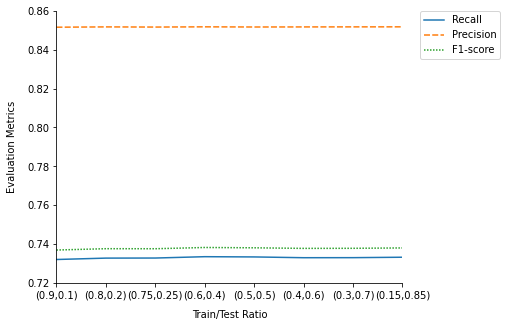

In [159]:
xgb_train_test_plot_data = pd.DataFrame({
    'Recall': recall_scores_tt_xgb,
    'Precision': precision_scores_tt_xgb,
    'F1-score': f1_scores_tt_xgb
})
fig, ax1 = plt.subplots(figsize=(6.2, 5))
xgb_tt_lineplot = sns.lineplot(data=xgb_train_test_plot_data, ax=ax1)
ax1.set(xlim=(0, 7))
ax1.set(ylim=(0.72, 0.86))
ax1.set_xlabel("Train/Test Ratio", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
xgb_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)", 
                   "(0.4,0.6)", "(0.3,0.7)", "(0.15,0.85)"])
sns.despine(fig)

### Naive Bayes

In [47]:
input_data_nb = input_data
input_data_nb['Exit_Code'] = input_data_nb['Exit_Code'].astype('category')
input_data_nb['Label_Log'] = input_data_nb['Label_Log'].astype('category')
input_data_nb['Label_Error'] = input_data_nb['Label_Error'].astype('category')
input_data_nb['Fault_Type'] = input_data_nb['Fault_Type'].astype('category')

C:\Users\aakas\AppData\Local\Temp\ipykernel_29464\3511227817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data_nb['Exit_Code'] = input_data_nb['Exit_Code'].astype('category')
C:\Users\aakas\AppData\Local\Temp\ipykernel_29464\3511227817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data_nb['Label_Log'] = input_data_nb['Label_Log'].astype('category')
C:\Users\aakas\AppData\Local\Temp\ipykernel_29464\3511227817.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [48]:
X_nb = input_data_nb[['Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error']]
y_nb = input_data_nb[['Fault_Type']]

In [49]:
le_y = LabelEncoder()
le_y.fit(y_nb)
y_nb = le_y.transform(y_nb)

le_exit_code = LabelEncoder()
le_exit_code.fit(X_nb.Exit_Code)
X_nb['Exit_Code'] = le_exit_code.transform(X_nb.Exit_Code)

le_time_out = LabelEncoder()
le_time_out.fit(X_nb.Time_Out)
X_nb['Time_Out'] = le_time_out.transform(X_nb.Time_Out)

le_label_log = LabelEncoder()
le_label_log.fit(X_nb.Label_Log)
X_nb['Label_Log'] = le_label_log.transform(X_nb.Label_Log)

le_label_error = LabelEncoder()
le_label_error.fit(X_nb.Label_Error)
X_nb['Label_Error'] = le_label_error.transform(X_nb.Label_Error)

C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aakas\AppData\Local\Temp\ipykernel_29464\2516623289.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_nb['Exit_Code'] = le_exit_code.transform(X_n

In [2073]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb, stratify=y_nb, random_state = 1)

In [2080]:
naive_bayes = MixedNB(alpha=0, categorical_features=[2,3,4,5])

naive_bayes.fit(X_train_nb, y_train_nb)

[17  2  8  6]


C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\mixed_naive_bayes\mixed_naive_bayes.py:370: UserWarning: alpha too small will result in numeric errors, setting alpha = 1e-10
  warnings.warn('alpha too small will result in numeric errors, '


MixedNB(alpha=1e-10, var_smoothing=1e-09)

### Naive Bayes - K-fold CV

In [50]:
accuracy_scores_nb =[]
precision_scores_nb =[]
recall_scores_nb =[]
f1_scores_nb =[]

In [51]:
cv_outer_nb = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [52]:
# K-fold CV

t0 = time()
y_nb = pd.DataFrame(y_nb)
count = 0
for train_ix_nb, test_ix_nb in cv_outer_nb.split(X_nb, y_nb):
    print(train_ix_nb)
    print(test_ix_nb)
    X_train_nb_cv, X_test_nb_cv = X_nb.iloc[train_ix_nb, :], X_nb.iloc[test_ix_nb, :]
    y_train_nb_cv, y_test_nb_cv = y_nb.iloc[train_ix_nb], y_nb.iloc[test_ix_nb]
    
    alphas = [50]
    
    for alpha in alphas:
    
        nb_random_kfold = MixedNB(alpha=alpha, categorical_features=[0,1,2,3])

        nb_random_kfold_best = nb_random_kfold.fit(X_train_nb_cv, y_train_nb_cv.values.flatten())
        
        filePath = "%s/Naive Bayes Models/KFold Models/kfold_model_%s.sav" %(path, count)
        os.makedirs(os.path.dirname(filePath), exist_ok=True)
        fileObj = open(filePath, 'wb')
        pickle.dump(nb_random_kfold_best, fileObj)
        fileObj.close()

        ypred_nb_random_kfold = nb_random_kfold_best.predict(X_test_nb_cv)
        accuracy_this_fold_nb = accuracy_score(y_test_nb_cv, ypred_nb_random_kfold)
        precision_this_fold_nb = precision_score(y_test_nb_cv, ypred_nb_random_kfold, average='weighted')
        recall_this_fold_nb = recall_score(y_test_nb_cv, ypred_nb_random_kfold, average='weighted')
        f1_score_this_fold_nb = f1_score(y_test_nb_cv, ypred_nb_random_kfold, average='weighted')   

        print("Accuracy: %.3f" %(accuracy_this_fold_nb))
        print("Precision: %.3f" %(precision_this_fold_nb))
        print("Recall: %.3f" %(recall_this_fold_nb))
        print("F1 Score: %.3f" %(f1_score_this_fold_nb))

        accuracy_scores_nb.append(accuracy_this_fold_nb)
        precision_scores_nb.append(precision_this_fold_nb)
        recall_scores_nb.append(recall_this_fold_nb)
        f1_scores_nb.append(f1_score_this_fold_nb)
        
        count = count + 1
        print("-------------------------------------------------------------------------------------------------------------------")

nested_cv_nb_time = time() - t0

[     0      1      2 ... 599990 599991 599993]
[    28     32     43 ... 599974 599985 599992]
[7 2 4 3]
Accuracy: 0.734
Precision: 0.852
Recall: 0.734
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
[     0      1      2 ... 599991 599992 599993]
[     9     11     38 ... 599969 599978 599990]
[7 2 4 3]
Accuracy: 0.734
Precision: 0.852
Recall: 0.734
F1 Score: 0.739
-------------------------------------------------------------------------------------------------------------------
[     0      1      2 ... 599991 599992 599993]
[     5     12     15 ... 599951 599965 599972]
[7 2 4 3]
Accuracy: 0.732
Precision: 0.851
Recall: 0.732
F1 Score: 0.737
-------------------------------------------------------------------------------------------------------------------
[     0      4      5 ... 599991 599992 599993]
[     1      2      3 ... 599956 599981 599984]
[7 2 4 3]
Accuracy: 0.731
Precision: 0.851
Recall

In [80]:
filePathAcc = "%s/Naive Bayes Models/KFold Models/kfold_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/Naive Bayes Models/KFold Models/kfold_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/Naive Bayes Models/KFold Models/kfold_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/Naive Bayes Models/KFold Models/kfold_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_nb, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_nb, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_nb, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_nb, filehandle)

In [56]:
filePathAcc = "%s/Naive Bayes Models/KFold Models/kfold_accuracy_scores.txt" %(path)

filePathPrec = "%s/Naive Bayes Models/KFold Models/kfold_precision_scores.txt" %(path)

filePathRecall = "%s/Naive Bayes Models/KFold Models/kfold_recall_scores.txt" %(path)

filePathF1 = "%s/Naive Bayes Models/KFold Models/kfold_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_nb = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_nb = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_nb = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_nb = data

In [57]:
accuracy_scores_nb = np.asarray(accuracy_scores_nb)
precision_scores_nb = np.asarray(precision_scores_nb)
recall_scores_nb = np.asarray(recall_scores_nb)
f1_scores_nb = np.asarray(f1_scores_nb)

print("NB K-fold Mean Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_nb.mean(), 
                                                                 (accuracy_scores_nb.std())))

print("NB K-fold Mean Precision: %.3f, with deviation of: %.3f" %(precision_scores_nb.mean(), 
                                                                  precision_scores_nb.std()))

print("NB K-fold Mean Recall: %.3f, with deviation of: %.3f" %(recall_scores_nb.mean(), 
                                                               recall_scores_nb.std()))

print("NB K-fold Mean F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_nb.mean(), 
                                                                 f1_scores_nb.std()))

NB K-fold Mean Accuracy: 0.733, with deviation of: 0.002
NB K-fold Mean Precision: 0.852, with deviation of: 0.001
NB K-fold Mean Recall: 0.733, with deviation of: 0.002
NB K-fold Mean F1 Score: 0.738, with deviation of: 0.002


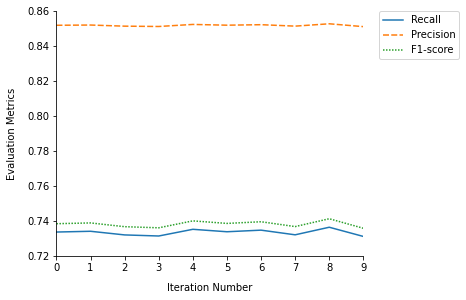

In [160]:
nb_kfold_plot_data = pd.DataFrame({
    'Recall': recall_scores_nb,
    'Precision': precision_scores_nb,
    'F1-score': f1_scores_nb
})
fig, ax1 = plt.subplots(figsize=(5.5, 4.5))
lineplot = sns.lineplot(data=nb_kfold_plot_data, ax=ax1)
ax1.set(xlim=(0, 9))
ax1.set(ylim=(0.72, 0.86))
ax1.set_xlabel("Iteration Number", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
sns.despine(fig)

### Naive Bayes - Train Test

In [53]:
accuracy_scores_tt_nb=[]
precision_scores_tt_nb=[]
recall_scores_tt_nb=[]
f1_scores_tt_nb=[]

In [54]:
t0 = time()
count = 0
for ratio in [(0.9,0.1), (0.8,0.2), (0.75,0.25), (0.6,0.4), (0.5,0.5)]:
    print("Train: %.2f and Test: %.2f" %(ratio[0], ratio[1]))
    
    X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(X_nb, y_nb, train_size=ratio[0], stratify=y_nb, random_state = 1)
    
    nb_random_tt = MixedNB(alpha=50, categorical_features=[0,1,2,3]).fit(X_train_tt, y_train_tt.values.flatten())
    
    filePath = "%s/Naive Bayes Models/TT Models/tt_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(nb_random_tt, fileObj)
    fileObj.close()
    
    ypred_nb_tt = nb_random_tt.predict(X_test_tt)
    
    accuracy_tt = accuracy_score(y_test_tt, ypred_nb_tt)
    precision_tt = precision_score(y_test_tt, ypred_nb_tt, average='weighted')
    recall_tt = recall_score(y_test_tt, ypred_nb_tt, average='weighted')
    f1_score_tt = f1_score(y_test_tt, ypred_nb_tt, average='weighted')   
    
    print("Accuracy: %.3f" %(accuracy_tt))
    print("Precision: %.3f" %(precision_tt))
    print("Recall: %.3f" %(recall_tt))
    print("F1 Score: %.3f" %(f1_score_tt))
    
    accuracy_scores_tt_nb.append(accuracy_tt)
    precision_scores_tt_nb.append(precision_tt)
    recall_scores_tt_nb.append(recall_tt)
    f1_scores_tt_nb.append(f1_score_tt)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")
    
train_test_time_nb = time() - t0

Train: 0.90 and Test: 0.10
[7 2 4 3]
Accuracy: 0.730
Precision: 0.851
Recall: 0.730
F1 Score: 0.735
-------------------------------------------------------------------------------------------------------------------
Train: 0.80 and Test: 0.20
[7 2 4 3]
Accuracy: 0.733
Precision: 0.852
Recall: 0.733
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
Train: 0.75 and Test: 0.25
[7 2 4 3]
Accuracy: 0.734
Precision: 0.852
Recall: 0.734
F1 Score: 0.738
-------------------------------------------------------------------------------------------------------------------
Train: 0.60 and Test: 0.40
[7 2 4 3]
Accuracy: 0.734
Precision: 0.852
Recall: 0.734
F1 Score: 0.739
-------------------------------------------------------------------------------------------------------------------
Train: 0.50 and Test: 0.50
[7 2 4 3]
Accuracy: 0.734
Precision: 0.852
Recall: 0.734
F1 Score: 0.738
------------------------------------

In [83]:
filePathAcc = "%s/Naive Bayes Models/TT Models/tt_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/Naive Bayes Models/TT Models/tt_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/Naive Bayes Models/TT Models/tt_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/Naive Bayes Models/TT Models/tt_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_tt_nb, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_tt_nb, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_tt_nb, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_tt_nb, filehandle)

In [59]:
filePathAcc = "%s/Naive Bayes Models/TT Models/tt_accuracy_scores.txt" %(path)

filePathPrec = "%s/Naive Bayes Models/TT Models/tt_precision_scores.txt" %(path)

filePathRecall = "%s/Naive Bayes Models/TT Models/tt_recall_scores.txt" %(path)

filePathF1 = "%s/Naive Bayes Models/TT Models/tt_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_tt_nb = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_tt_nb = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_tt_nb = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_tt_nb = data

In [60]:
accuracy_scores_tt_nb = np.asarray(accuracy_scores_tt_nb)
precision_scores_tt_nb = np.asarray(precision_scores_tt_nb)
recall_scores_tt_nb = np.asarray(recall_scores_tt_nb)
f1_scores_tt_nb = np.asarray(f1_scores_tt_nb)

print("NB TT Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_tt_nb.mean(), 
                                                                 (accuracy_scores_tt_nb.std())))

print("NB TT Precision: %.3f, with deviation of: %.3f" %(precision_scores_tt_nb.mean(), 
                                                                  precision_scores_tt_nb.std()))

print("NB TT Recall: %.3f, with deviation of: %.3f" %(recall_scores_tt_nb.mean(), 
                                                               recall_scores_tt_nb.std()))

print("NB TT F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_tt_nb.mean(), 
                                                                 f1_scores_tt_nb.std()))

NB TT Accuracy: 0.733, with deviation of: 0.001
NB TT Precision: 0.852, with deviation of: 0.000
NB TT Recall: 0.733, with deviation of: 0.001
NB TT F1 Score: 0.738, with deviation of: 0.001


C:\Users\aakas\AppData\Local\Temp\ipykernel_7836\538036879.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  nb_tt_lineplot.set_xticklabels(["(0.9,0.1)", " ", "(0.8,0.2)", " ", "(0.75,0.25)", " ", "(0.6,0.4)", " ", "(0.5,0.5)"])


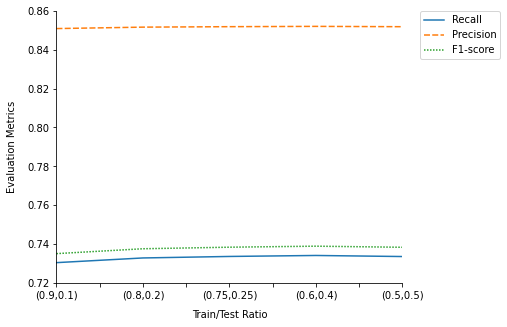

In [161]:
nb_train_test_plot_data = pd.DataFrame({
    'Recall': recall_scores_tt_nb,
    'Precision': precision_scores_tt_nb,
    'F1-score': f1_scores_tt_nb
})
fig, ax1 = plt.subplots(figsize=(6.2, 5))
nb_tt_lineplot = sns.lineplot(data=nb_train_test_plot_data, ax=ax1)
ax1.set(xlim=(0, 4))
ax1.set(ylim=(0.72, 0.86))
nb_tt_lineplot.set_xticklabels(["(0.9,0.1)", " ", "(0.8,0.2)", " ", "(0.75,0.25)", " ", "(0.6,0.4)", " ", "(0.5,0.5)"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlabel("Train/Test Ratio", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
sns.despine(fig)

# Stage 2:

## Supervised fault type prediction - Naive Model

In [68]:
naive_model_nop = pickle.load(open("%s/Naive Models/naive_model_nop.sav" %(path), 'rb'))

naive_model_flp = pickle.load(open("%s/Naive Models/naive_model_flp.sav" %(path), 'rb'))

naive_model_none = pickle.load(open("%s/Naive Models/naive_model_none.sav" %(path), 'rb'))

In [69]:
t0 = time()
y_pred_naive_nop = naive_model_nop.predict(X_test)
naive_pred_time_nop = time() - t0

In [70]:
print("Prediction time for %i samples: %d" %(X_test.shape[0], naive_pred_time_nop))

Prediction time for 301025 samples: 0


In [71]:
naive_nop_accuracy = accuracy_score(y_test, y_pred_naive_nop)
print("Naive Model NOP Accuracy: %s" %(naive_nop_accuracy))

Naive Model NOP Accuracy: 0.3356099991695042


In [72]:
naive_nop_recall = recall_score(y_test, y_pred_naive_nop, average='weighted')
print("Naive Model NOP Recall: %s" %(naive_nop_recall))

Naive Model NOP Recall: 0.3356099991695042


In [73]:
naive_nop_precision = precision_score(y_test, y_pred_naive_nop, average='weighted')
print("Naive Model NOP Precision: %s" %(naive_nop_precision))

Naive Model NOP Precision: 0.1126340715425546


C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
naive_nop_f1 = f1_score(y_test, y_pred_naive_nop, average='weighted')
print("Naive Model NOP Weighted F1 score: %s" %(naive_nop_f1))

Naive Model NOP Weighted F1 score: 0.16866311514976917


In [75]:
t0 = time()
y_pred_naive_flp = naive_model_flp.predict(X_test)
naive_pred_time_flp = time() - t0

In [76]:
print("Prediction time for %i samples: %d" %(X_test.shape[0], naive_pred_time_flp))

Prediction time for 301025 samples: 0


In [77]:
naive_flp_accuracy = accuracy_score(y_test, y_pred_naive_flp)
print("Naive Model FLP Accuracy: %s" %(naive_flp_accuracy))

Naive Model FLP Accuracy: 0.3321916784320239


In [78]:
naive_flp_recall = recall_score(y_test, y_pred_naive_flp, average='weighted')
print("Naive Model FLP Recall: %s" %(naive_flp_recall))

Naive Model FLP Recall: 0.3321916784320239


In [79]:
naive_flp_precision = precision_score(y_test, y_pred_naive_flp, average='weighted')
print("Naive Model FLP Precision: %s" %(naive_flp_precision))

Naive Model FLP Precision: 0.11035131121948517


C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
naive_flp_f1 = f1_score(y_test, y_pred_naive_flp, average='weighted')
print("Naive Model FLP Weighted F1 score: %s" %(naive_flp_f1))

Naive Model FLP Weighted F1 score: 0.16566881929388352


In [81]:
t0 = time()
y_pred_naive_none = naive_model_none.predict(X_test)
naive_pred_time_none = time() - t0

In [82]:
print("Prediction time for %i samples: %d" %(X_test.shape[0], naive_pred_time_none))

Prediction time for 301025 samples: 0


In [83]:
naive_none_accuracy = accuracy_score(y_test, y_pred_naive_none)
print("Naive Model NONE Accuracy: %s" %(naive_none_accuracy))

Naive Model NONE Accuracy: 0.3321983223984719


In [84]:
naive_none_recall = recall_score(y_test, y_pred_naive_none, average='weighted')
print("Naive Model NONE Recall: %s" %(naive_none_recall))

Naive Model NONE Recall: 0.3321983223984719


In [85]:
naive_none_precision = precision_score(y_test, y_pred_naive_none, average='weighted')
print("Naive Model NONE Precision: %s" %(naive_none_precision))

Naive Model NONE Precision: 0.11035572540435909


C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
naive_none_f1 = f1_score(y_test, y_pred_naive_none, average='weighted')
print("Naive Model NONE Weighted F1 score: %s" %(naive_none_f1))

Naive Model NONE Weighted F1 score: 0.16567461998552305


In [87]:
naive_accuracy_scores = np.array([naive_nop_accuracy, naive_flp_accuracy, naive_none_accuracy])
naive_recall_scores = np.array([naive_nop_recall, naive_flp_recall, naive_none_recall])
naive_precision_scores = np.array([naive_nop_precision, naive_flp_precision, naive_none_precision])
naive_f1_scores = np.array([naive_nop_f1, naive_flp_f1, naive_none_f1])

In [88]:
print("Naive Mean Accuracy: %.3f, with deviation of: %.3f" %(naive_accuracy_scores.mean(), 
                                                                 (naive_accuracy_scores.std())))

print("Naive Mean Recall Score: %.3f, with deviation of: %.3f" %(naive_recall_scores.mean(), 
                                                                 naive_recall_scores.std()))

print("Naive Mean Precision Score: %.3f, with deviation of: %.3f" %(naive_precision_scores.mean(), 
                                                                 naive_precision_scores.std()))

print("Naive Mean F1 Score: %.3f, with deviation of: %.3f" %(naive_f1_scores.mean(), 
                                                                 naive_f1_scores.std()))

Naive Mean Accuracy: 0.333, with deviation of: 0.002
Naive Mean Recall Score: 0.333, with deviation of: 0.002
Naive Mean Precision Score: 0.111, with deviation of: 0.001
Naive Mean F1 Score: 0.167, with deviation of: 0.001


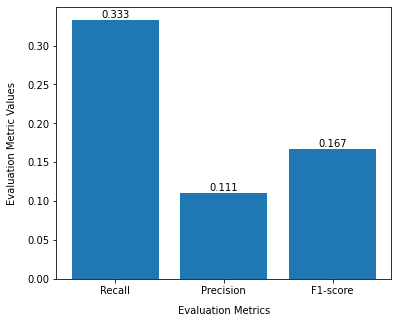

In [165]:
fig, ax1 = plt.subplots(figsize=(6, 5))

values = [
    round(np.mean([naive_nop_recall, naive_flp_recall, naive_none_recall]), 3),
    round(np.mean([naive_nop_precision, naive_flp_precision, naive_none_precision]), 3),
    round(np.mean([naive_nop_f1, naive_flp_f1, naive_none_f1]), 3)
]

ax1.bar(['Recall', 'Precision', 'F1-score'], values)

for container in ax1.containers:
    ax1.bar_label(container)
    
ax1.set_xlabel("Evaluation Metrics", labelpad=10)
ax1.set_ylabel("Evaluation Metric Values", labelpad=10)

plt.show()

## Supervised fault type prediction - Random Forest

In [120]:
t0 = time()
y_pred_rf = rfc.predict(X_test)
rf_pred_time = time() - t0

In [121]:
print("Prediction time for %i samples: %d" %(X_test.shape[0], rf_pred_time))

Prediction time for 301025 samples: 0


In [122]:
rf_cls_report = classification_report(y_test, 
                                      y_pred_rf,
                                      output_dict=True)

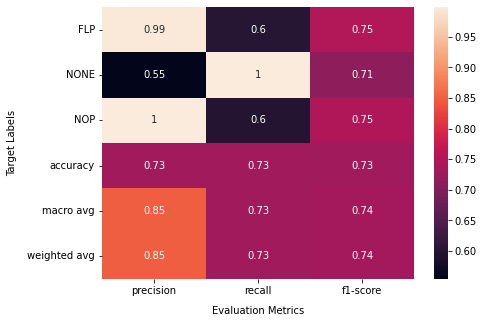

In [166]:
fig, ax1 = plt.subplots(figsize=(7, 5))
sns.heatmap(pd.DataFrame(rf_cls_report).iloc[:-1, :].T, annot=True)
ax1.set_xlabel("Evaluation Metrics", labelpad=10)
ax1.set_ylabel("Target Labels", labelpad=10)
plt.show()

In [131]:
rfc_importance = rfc.feature_importances_

In [36]:
for i,v in enumerate(rfc_importance):
    print('Feature: %0d, Score: %.3f' % (i,v))

Feature: 0, Score: 0.216
Feature: 1, Score: 0.127
Feature: 2, Score: 0.497
Feature: 3, Score: 0.261


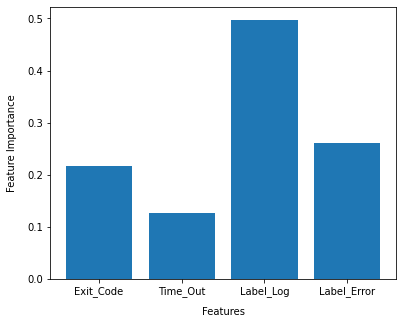

In [167]:
fig, ax1 = plt.subplots(figsize=(6.2, 5))
plt.bar(['Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error'], rfc_importance)
ax1.set_xlabel("Features", labelpad=10)
ax1.set_ylabel("Feature Importance", labelpad=10)
plt.show()

In [ ]:
rfc_predictions = X_test.copy()
rfc_predictions['Predicted_Fault'] = y_pred_rf
rfc_predictions['Actual_Fault'] = y_test
rfc_predictions.to_csv('rfc_predictions.csv')

# Plots

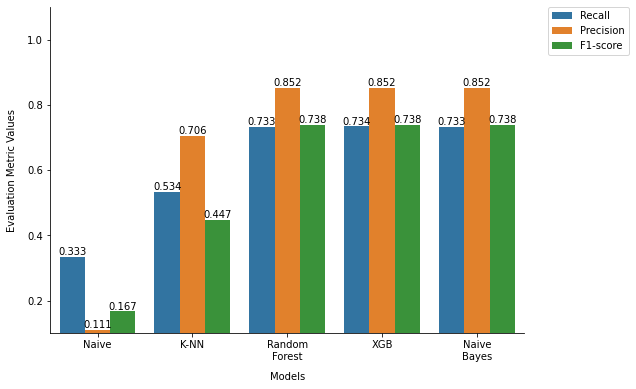

In [170]:
df = pd.DataFrame({
    'Models': ['Naive', 'K-NN', 'Random\nForest', 'XGB', 'Naive\nBayes'],
#     'Accuracy': [round(naive_accuracy_scores.mean(),3), round(knn_accuracy,3), round(accuracy_scores.mean(),3), 
#                  round(nested_cv_xgb_accuracy,3)],
    'Recall': [round(naive_recall_scores.mean(),3), 
               round(recall_scores_knn.mean(),3), 
               round(recall_scores.mean(),3),
               round(recall_scores_nested_cv_xgb.mean(),3), 
               round(recall_scores_nb.mean(),3)],
    'Precision': [round(naive_precision_scores.mean(),3), 
                  round(precision_scores_knn.mean(),3), 
                  round(precision_scores.mean(),3), 
                  round(precision_scores_nested_cv_xgb.mean(),3), 
                  round(precision_scores_nb.mean(),3)],
    'F1-score': [round(naive_f1_scores.mean(),3), 
                 round(f1_scores_knn.mean(),3), 
                 round(f1_scores.mean(),3), 
                 round(f1_scores_nested_cv_xgb.mean(),3), 
                 round(f1_scores_nb.mean(),3)]
})
xlabel = 'Models'
ylabel = 'Evaluation Metric Values'
fig, ax1 = plt.subplots(figsize=(8.5, 6))
tidy = df.melt(id_vars=xlabel).rename(columns=str.title)
tidy = tidy.rename(columns={"Value": ylabel, "Variable": "Metrics"})
sns.barplot(x=xlabel, y=ylabel, hue='Metrics', data=tidy, ax=ax1)
ax1.set(ylim=(0.1, 1.1))

for container in ax1.containers:
    ax1.bar_label(container)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlabel(xlabel, labelpad=10)
ax1.set_ylabel(ylabel, labelpad=10)

sns.despine(fig)